<a href="https://colab.research.google.com/github/Affan009/Bitcoin_Trading_Strategy_Py/blob/main/Notebook/Bitcoin_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import yfinance as yf
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Setting Time Range

In [ ]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2024, 12, 31)

# Fetching Bitcoin Data

In [ ]:
btc = yf.download('BTC-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


# Cleaning and Preparing Data

In [ ]:
btc.columns = btc.columns.get_level_values(0)
btc[btc.columns.values] = btc[btc.columns.values].ffill()
btc

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800
...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185


# Creating Labels for the Data

In [ ]:
btc['short_mavg'] = btc['Close'].rolling(window=10, min_periods=1, center=False).mean()

btc['long_mavg'] = btc['Close'].rolling(window=60, min_periods=1, center=False).mean()

btc['signal'] = np.where(btc['short_mavg'] > btc['long_mavg'], 1.0, 0.0)

In [ ]:
btc

Price,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
Date,,,,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550,314.248993,314.248993,0.0
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,314.640503,314.640503,0.0
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,303.454336,303.454336,0.0
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,293.639503,293.639503,0.0
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,289.806403,289.806403,0.0
...,...,...,...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,98221.573438,90976.569792,1.0
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,97023.999219,91380.854818,1.0
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,96536.238281,91754.912109,1.0


# Feature Engineering

In [ ]:
# Exponential Moving Average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
btc['EMA10'] = EMA(btc, 10)
btc['EMA30'] = EMA(btc, 30)
btc['EMA200'] = EMA(btc, 200)
btc.head()

# Rate of Change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
btc['ROC10'] = ROC(btc['Close'], 10)
btc['ROC30'] = ROC(btc['Close'], 30)

# Price Momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
btc['MOM10'] = MOM(btc['Close'], 10)
btc['MOM30'] = MOM(btc['Close'], 30)

# Relative Strength Index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
btc['RSI10'] = RSI(btc['Close'], 10)
btc['RSI30'] = RSI(btc['Close'], 30)
btc['RSI200'] = RSI(btc['Close'], 200)

# Stochastic Oscillator
def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

btc['%K10'] = STOK(btc['Close'], btc['Low'], btc['High'], 10)
btc['%D10'] = STOD(btc['Close'], btc['Low'], btc['High'], 10)
btc['%K30'] = STOK(btc['Close'], btc['Low'], btc['High'], 30)
btc['%D30'] = STOD(btc['Close'], btc['Low'], btc['High'], 30)
btc['%K200'] = STOK(btc['Close'], btc['Low'], btc['High'], 200)
btc['%D200'] = STOD(btc['Close'], btc['Low'], btc['High'], 200)

# Moving Average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
btc['MA21'] = MA(btc, 10)
btc['MA63'] = MA(btc, 30)
btc['MA252'] = MA(btc, 200)
btc

Price,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550,314.248993,314.248993,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,314.640503,314.640503,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,303.454336,303.454336,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,293.639503,293.639503,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,289.806403,289.806403,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,98221.573438,90976.569792,1.0,98005.135115,96976.320259,...,56.225209,22.495968,35.719425,24.359641,39.426332,78.912056,82.510005,98221.573438,98727.185156,70867.881836
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,97023.999219,91380.854818,1.0,97306.903163,96794.935686,...,55.862701,13.918292,26.893774,13.313601,28.804484,76.155111,79.967628,97023.999219,98667.262760,70991.144727
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,96536.238281,91754.912109,1.0,96917.271622,96689.709492,...,56.037236,28.267841,21.560701,19.454295,19.042512,77.844236,77.637134,96536.238281,98650.978125,71130.304219


In [ ]:
# Removing unecessary columns
btc = btc.drop(['High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

# Visualizing Data

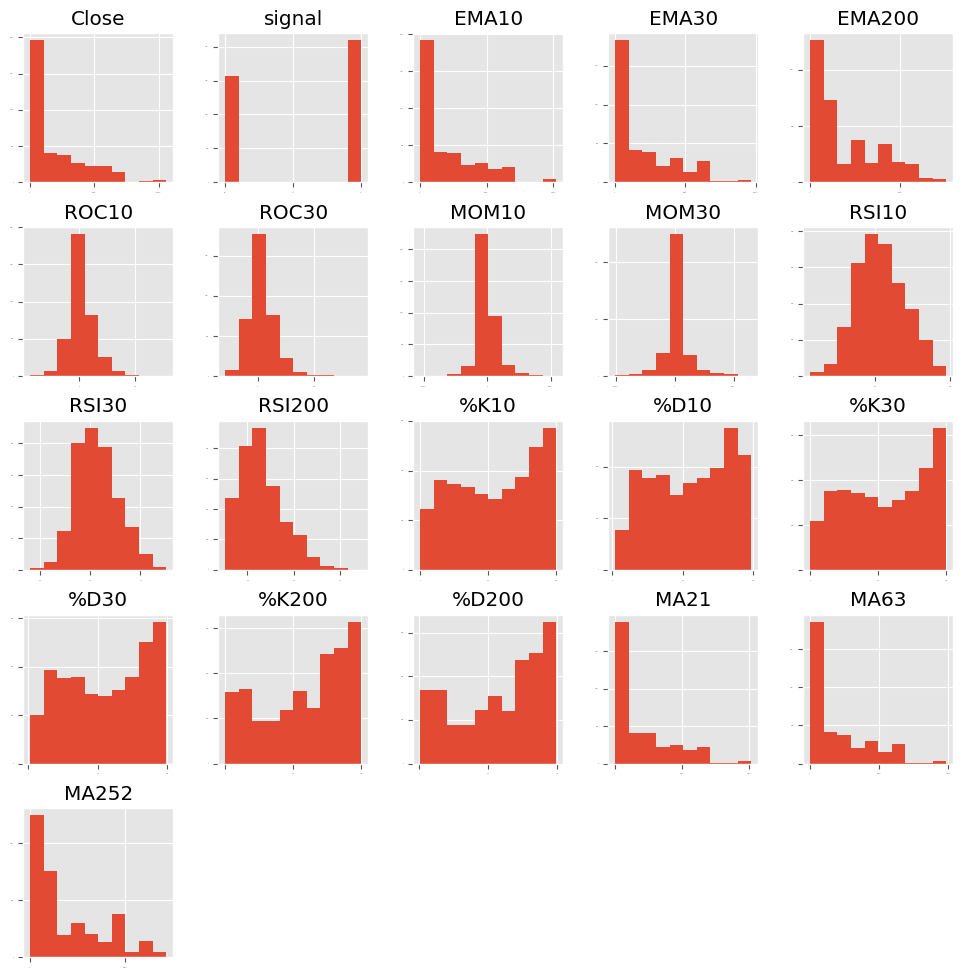

In [ ]:
btc.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

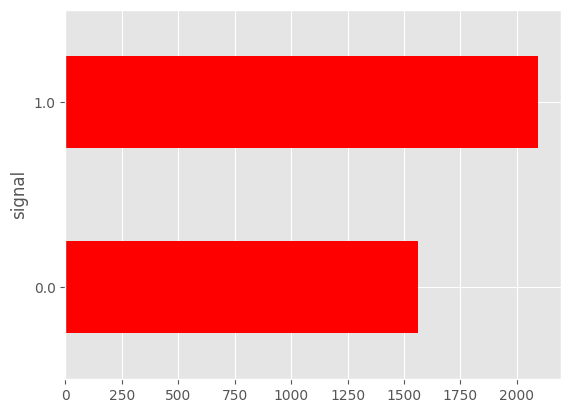

In [ ]:
fig = plt.figure()
plot = btc.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}, xlabel='Price', ylabel='Price'>

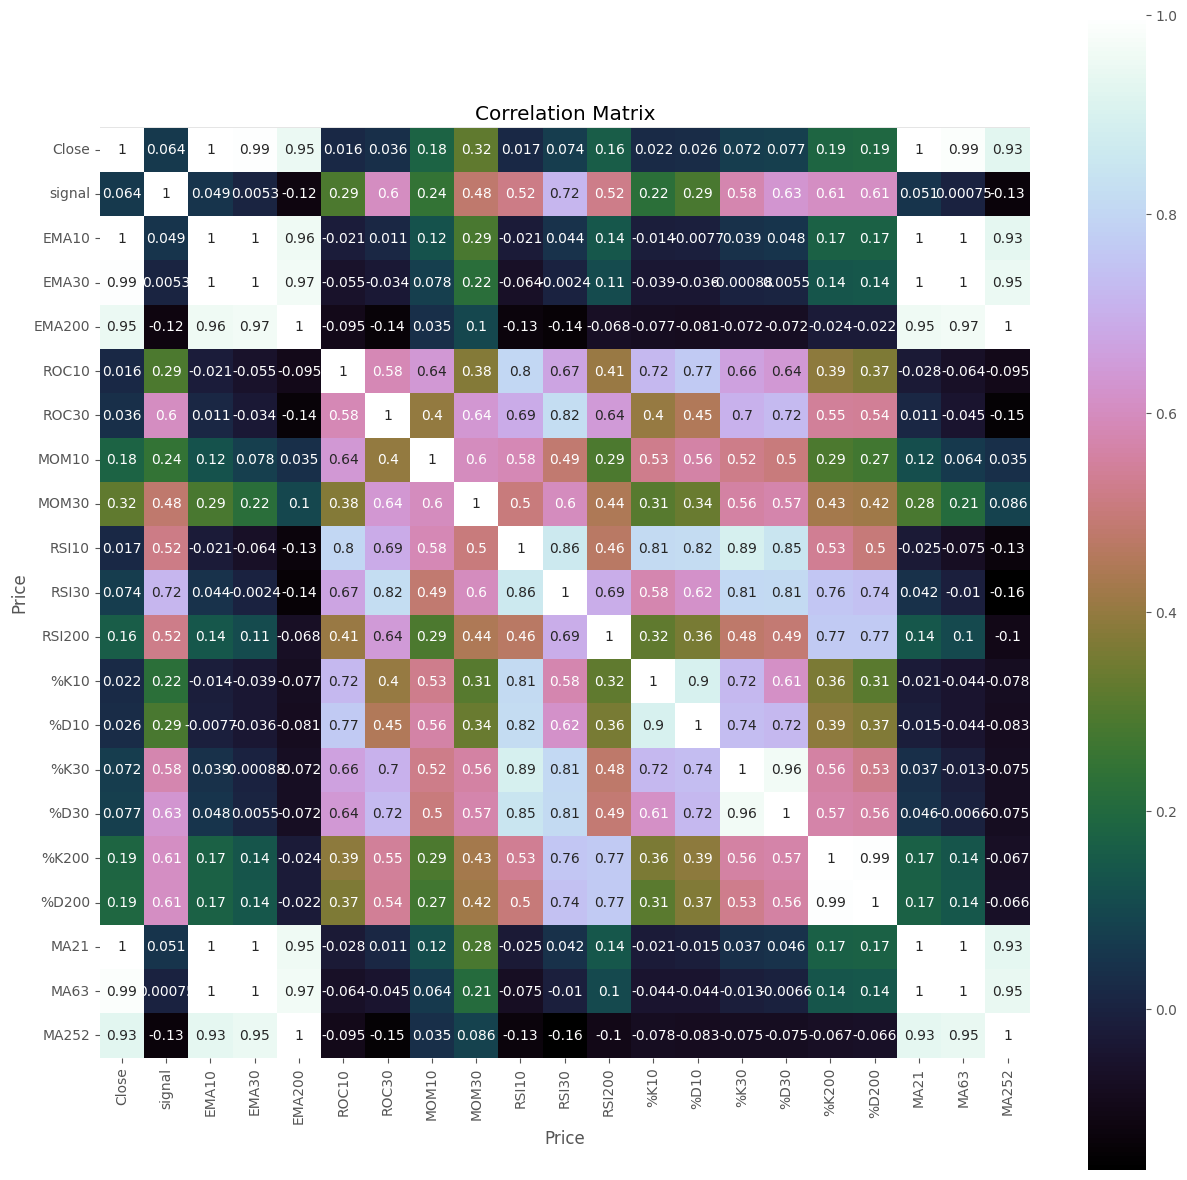

In [ ]:
correlation = btc.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# Train Test Split

In [ ]:
Y= btc["signal"]
X = btc.loc[:, btc.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [ ]:
num_folds = 10
seed = 7
scoring = 'accuracy'

# Model Tuning

In [ ]:
# Random Forest Model is choosen
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.951045 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#7 0.925027 (0.009609) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.926053 (0.008821) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.947963 (0.012612) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#3 0.948989 (0.011306) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.924686 (0.011342) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.925371 (0.011925) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#2 0.949679 (0.013513) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.951045 (0.009318) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


# Model Fitting

In [ ]:
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

# Model Testing and Results

In [ ]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.948016415868673
[[304  22]
 [ 16 389]]
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       326
         1.0       0.95      0.96      0.95       405

    accuracy                           0.95       731
   macro avg       0.95      0.95      0.95       731
weighted avg       0.95      0.95      0.95       731



<Axes: xlabel='Predicted', ylabel='Actual'>

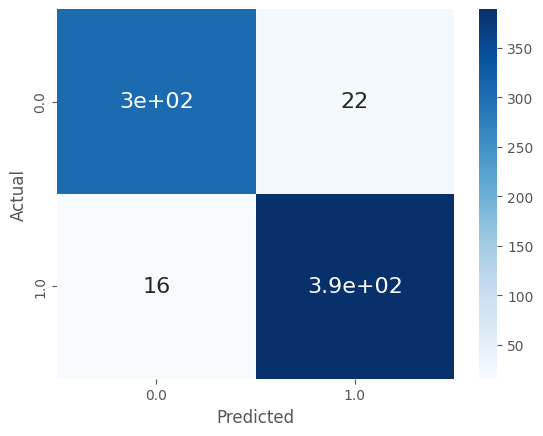

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# Feature Importance

Text(0.5, 0, 'Variable Importance')

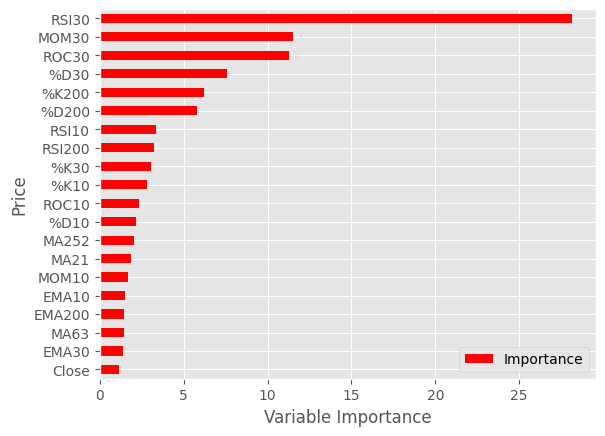

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

# Backtesting the Strategy

<Axes: >

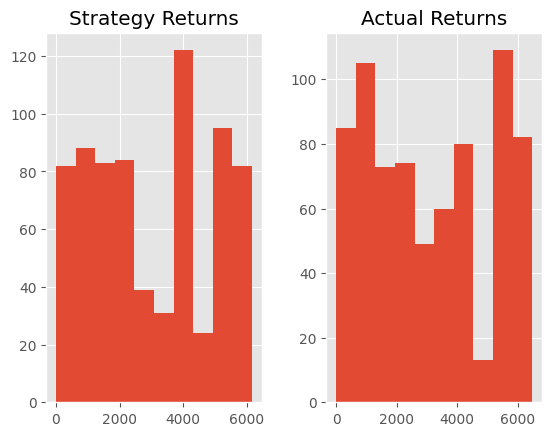

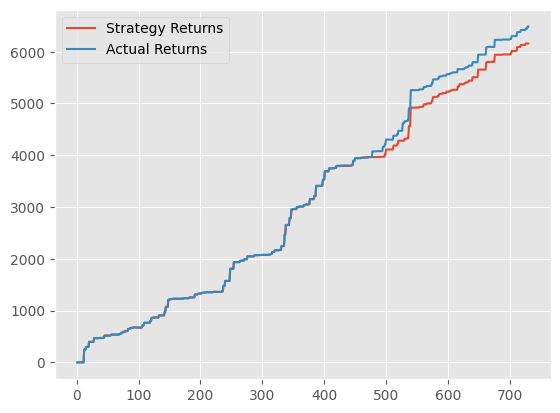

In [ ]:
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [ ]:
cumulative_strategy_returns = (1 + backtestdata['Strategy Returns']).cumprod()
cumulative_actual_returns = (1 + backtestdata['Actual Returns']).cumprod()

def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

sharpe_strategy = sharpe_ratio(backtestdata['Strategy Returns'])
sharpe_actual = sharpe_ratio(backtestdata['Actual Returns'])

print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
print(f"Sharpe Ratio (Actual): {sharpe_actual:.2f}")

Sharpe Ratio (Strategy): 4.24
Sharpe Ratio (Actual): 4.37
